# 3.6 決定木学習

2018/05/04 u110

## 3.6.1 情報利得の最大化: できるだけ高い効果を得る

- 情報利得(information gain): 葉の集合の要素についてのばらつきが少なくなること
    - 集合ないの要素が同じクラスに属すること
    - ばらつきがなくなることを「葉が純粋になる」と表現する
    - この場合は木が深くなりすぎ、過学習となってしまう
    - 深さの制限＝剪定(prune)をしていくことで汎化性能をあげるらしい。

## 3.6.2 決定木の構築

- 決定木学習
    - 特徴空間を矩形分割することで決定境界を構築
    - 決定木が深くなればなるほど、境界は複雑になり過学習になりがち
    - 不純度の条件、制約を設けてトレーニングする

## 3.6.3 ランダムフォレストを使って弱い学習アルゴリズムと強い学習アルゴリズムを結合する

- 復元抽出：　重複を許したデータの抽出
- 非復元抽出：　その逆。重複を許さない

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

/Users/itouyuu/.local/share/virtualenvs/public-jupyter-W5iW7UT_/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [19]:
""" iris dataset の用意 """
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

iris = load_iris()
X = iris.data[:, [2, 3]]
y = iris.target

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=0
)

sc = StandardScaler()

#　トレーニングデータの平均と標準偏差を計算

sc.fit(X_train)

# 平均、標準偏差を用いて標準化

X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

""" トレーニングデータとテストデータの特徴量を行方向に結合
"""
X_combined_std = np.vstack((X_train_std, X_test_std))

""" トレーニングデータとテストデータのクラスラベルの結合
"""
y_combined = np.hstack((y_train, y_test))

In [20]:
from matplotlib.colors import ListedColormap

def plot_decision_reqions(X, y, classifier, test_idx=None, resolusion=0.02):
    
    # マーカーとカラーマップの準備
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    
    # 決定領域のプロット
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() -1 , X[:, 1].max() + 1
    
    # グリッドポイントの生成
    xx1, xx2 = np.meshgrid(
        np.arange(x1_min, x1_max, resolusion),
        np.arange(x2_min, x2_max, resolusion)
    )
    
    # 各特徴量を1次元配列に変換して予測を実行
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    
    # 予測結果を元のグリッドポイントのデータサイズに変換
    z = Z.reshape(xx1.shape)
    
    # グリッドポイントの等高線のプロット
    plt.contour(xx1, xx2, z, alpha=0.4, cmap=cmap)
    # 軸の範囲の設定
    plt.xlim(xx1.min(), xx1.max())
    
    # クラス毎にサンプルをプロット
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
                    alpha=0.8, c=cmap(idx), marker=markers[idx], label=cl
        )
    # テストサンプルを目立たせる
    if test_idx:
        X_test, y_test = X[test_idx, :], y[test_idx]
        plt.scatter(
            x=X_test[:, 0], 
            y=X_test[:, 1], 
            c="gray", alpha=1.0, 
            linewidths=.1, marker='.', s=55, label='test set'
        )

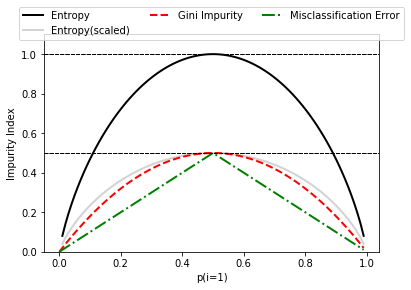

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# ジニ不純度の関数を定義
def gini(p):
    return p * (1 - p) + (1 - p) * (1 - (1 - p))

# エントロピー
def entropy(p):
    return - p * np.log2(p) - (1 - p) * np.log2((1 - p))

# 分類誤差
def error(p):
    return 1 - np.max([p, 1 - p])

# 確率を表す配列の生成
x = np.arange(0.0, 1.0, 0.01)

# 配列の値をもとにエントロピー、分類誤差を計算
ent = [entropy(p) if p !=0 else None for p in x]
sc_ent = [e*0.5 if e else None for e in ent]
err = [error(i) for i in x]

# plot
fig = plt.figure()
ax = plt.subplot(111)

# エントロピーｘ2、ジニ不純度、分類誤差
for i, lab, ls, c, in zip([ent, sc_ent, gini(x), err],
                          ['Entropy', 'Entropy(scaled)', 'Gini Impurity', 'Misclassification Error'],
                          ['-', '-', '--', '-.'],
                          ['black', 'lightgray', 'red', 'green', 'cyan']
                         ):
    line = ax.plot(x, i, label=lab, linestyle=ls, lw=2, color=c)
    
    # 凡例
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=3, fancybox=True, shadow=False)
    
    # 水平破線
    ax.axhline(y=0.5, linewidth=1, color='k', linestyle='--')
    ax.axhline(y=1.0, linewidth=1, color='k', linestyle='--')
    
# 横軸の上下限
plt.ylim([0, 1.1])

plt.xlabel('p(i=1)')
plt.ylabel('Impurity Index')
plt.show()

# 不純度条件の視覚化

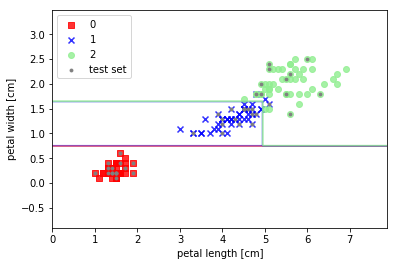

In [24]:
from sklearn.tree import DecisionTreeClassifier


# エントロピーを指標とする決定木のインスタンスを生成
tree = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=0)

# 決定木のモデルにトレーニングデータを適合させる
tree.fit(X_train, y_train)

X_combined = np.vstack((X_train, X_test))
y_combined = np.hstack((y_train, y_test))

plot_decision_reqions(X_combined, y_combined, classifier=tree, test_idx=range(105, 150))
plt.xlabel("petal length [cm]")
plt.ylabel("petal width [cm]")
plt.legend(loc="best")
plt.show()

In [27]:
from sklearn.tree import export_graphviz

export_graphviz(
    tree, 
    out_file="tree.dot",
    feature_names=['petal length', 'petal width']
)

# > dot -Tpng tree.dot -o tree.png

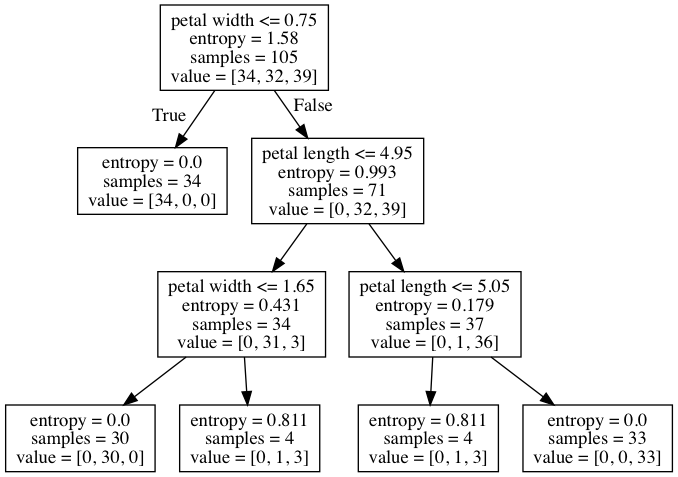

In [31]:
from IPython.display import display_png, Image


display(Image("./tree.png"))

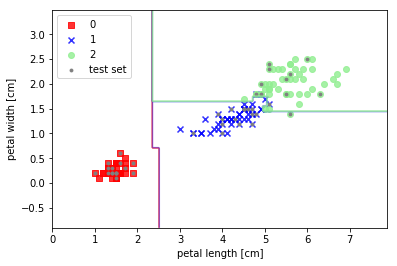

In [34]:
from sklearn.ensemble import RandomForestClassifier


# エントロピーを指標とするランダムフォレストのインスタンスを生成
forest = RandomForestClassifier(
    criterion='entropy',
    n_estimators=10,
    random_state=1,
    n_jobs=2
)

# fit
forest.fit(X_train, y_train)
plot_decision_reqions(X_combined, y_combined, classifier=forest, test_idx=range(105, 150))
plt.xlabel('petal length [cm]')
plt.ylabel('petal width [cm]')
plt.legend(loc='upper left')
plt.show()